In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from convex_lib import ConvexNN
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib

In [4]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

## 2D dataset -> Monotonic

In [5]:
from scipy.stats import multivariate_normal

def gaussian(x1_mean, x2_mean, std, x1_grid, x2_grid, yscale):
    rv = multivariate_normal([x1_mean, x2_mean], [[std, 0.], [0., std]])
    data = np.dstack((x1_grid.reshape(-1), x2_grid.reshape(-1)))
    z = rv.pdf(data)
    z = z/z.max()*yscale
    return z.reshape(x1_grid.shape)

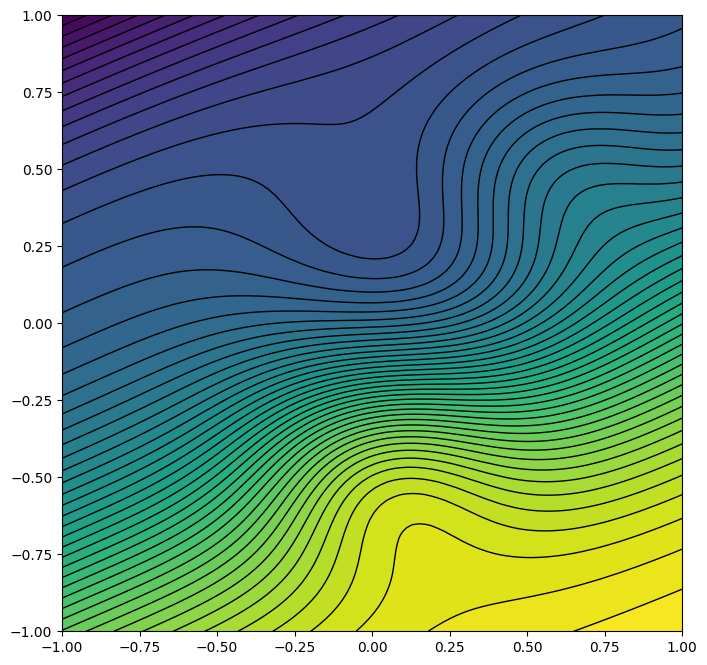

In [6]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.9, num_points)
X1, X2 = np.meshgrid(X1, X2)
# Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
Y = -X1*0.5 + X2
Y = np.sin(Y*1.3 + 0.5)*0.5+Y
Y += gaussian(0, 0.5, 0.5, X1, X2, 0.5)
Y -= gaussian(-0.75, 1.0, 1, X1, X2, 0.1)
Y += gaussian(0.75, 1.0, 1.2, X1, X2, 0.75)
Y -= gaussian(1.0, 1.5, 0.4, X1, X2, 1.0)
Y -= gaussian(-0.25, -0.75, 0.4, X1, X2, 1.3)




####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = -Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

# %matplotlib tk
# ax = plt.figure(figsize=(8,6)).add_subplot(projection='3d')
# ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# plt.show()

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, Y, levels=LVLs)
cs = plt.contour(X1, X2, Y, levels=LVLs, linestyles="None", colors="k", linewidths=1)

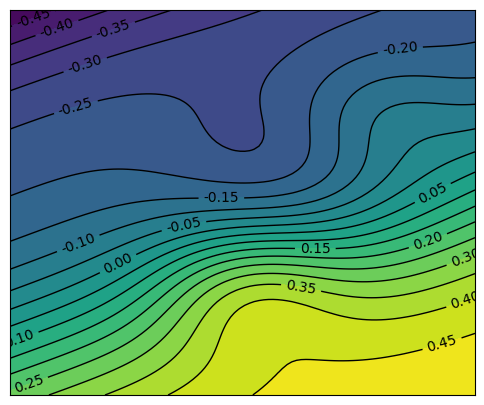

In [27]:
LVLs = 20
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, Y, levels=LVLs)
cs = plt.contour(X1, X2, Y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/invex_contour_global.pdf", bbox_inches='tight')

In [9]:
# ! mkdir outputs/04.2_locality_contour_viz

In [10]:
# gaussian(0, 0, 4, X1, X2, 0.2).shape

In [11]:
# from scipy.stats import multivariate_normal

# x, y = np.mgrid[-10:10:.1, -10:10:.1]
# rv = multivariate_normal([0, 0], [[1.0, 0.], [0., 1.0]])
# data = np.dstack((x, y))
# z = rv.pdf(data)
# z = z/z.max()
# plt.contourf(x, y, z)
# plt.axis("equal")
# plt.show()

In [12]:
# z.max(), z.min()

# Convex NN

In [13]:
EPOCHS = 5000
# actf = nn.LeakyReLU
actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

In [14]:
cvxNet = ConvexNN([2, 15, 15, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

Epoch: 0, Loss:0.08091622591018677


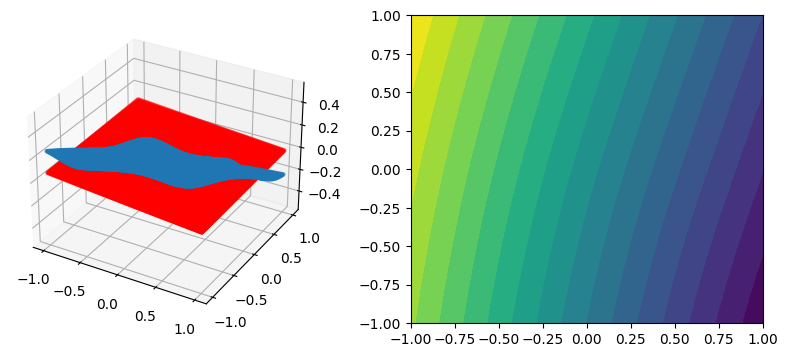

Epoch: 100, Loss:0.004597357474267483
Epoch: 200, Loss:0.003981493413448334
Epoch: 300, Loss:0.002804091665893793
Epoch: 400, Loss:0.0027486905455589294
Epoch: 500, Loss:0.0027057891711592674
Epoch: 600, Loss:0.0026525529101490974
Epoch: 700, Loss:0.0026225289329886436
Epoch: 800, Loss:0.0026027869898825884
Epoch: 900, Loss:0.0025542285293340683
Epoch: 1000, Loss:0.0025636928621679544
Epoch: 1100, Loss:0.002547743497416377
Epoch: 1200, Loss:0.0025480673648416996
Epoch: 1300, Loss:0.0025026954244822264
Epoch: 1400, Loss:0.0024981608148664236
Epoch: 1500, Loss:0.002476075431331992
Epoch: 1600, Loss:0.00247796718031168
Epoch: 1700, Loss:0.0024691508151590824
Epoch: 1800, Loss:0.0024729103315621614
Epoch: 1900, Loss:0.00247688265517354
Epoch: 2000, Loss:0.0024581854231655598
Epoch: 2100, Loss:0.00242750346660614
Epoch: 2200, Loss:0.0024260380305349827
Epoch: 2300, Loss:0.0024308208376169205
Epoch: 2400, Loss:0.0024198247119784355
Epoch: 2500, Loss:0.00242740660905838
Epoch: 2600, Loss:0.00

In [15]:
# %matplotlib notebook
# %matplotlib tk
%matplotlib inline

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

In [ ]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

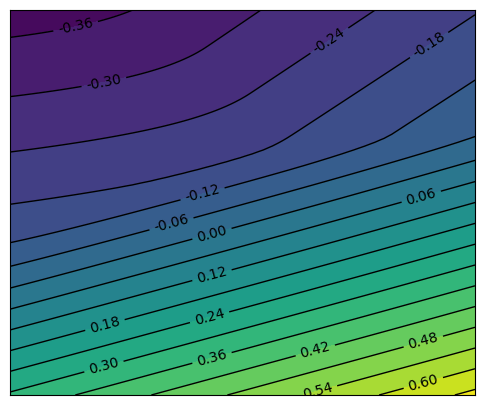

In [26]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
%matplotlib inline
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# minima = xx[y_.argmin()]
# plt.scatter(*minima.tolist(), s=100, edgecolors="red")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/convex_contour_global.pdf", bbox_inches='tight')

## Invex NN

In [21]:
# EPOCHS = 5000
# learning_rate = 0.005
# criterion = nn.MSELoss()

In [22]:
# cvxNet = nn.Sequential(
#     nn.BatchNorm1d(2),
#     irf.ResidualFlow(2, [15], activation=nflib.res_flow.Swish),
#     nn.BatchNorm1d(2),
#     DistanceRegressor(2),
# )

# optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [23]:
# %matplotlib tk
# fig = plt.figure(figsize=(15,6))
# ax = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122)

# for epoch in range(EPOCHS):

#     yout = -cvxNet(xx)    
#     loss = criterion(yout, yy)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if epoch%100 == 0 or epoch==EPOCHS-1:
#         print(f'Epoch: {epoch}, Loss:{float(loss)}')
#         ax.clear()
#         ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
#         ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
#         ax2.clear()
#         ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

#         fig.canvas.draw()
#         plt.pause(0.01)
# plt.close()

In [24]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

In [25]:
# LVLs = 20

# y_ = -cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

# plt.figure(figsize=(8,8))
# plt.contourf(X1, X2, y_, levels=LVLs)
# cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
# plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# minima = xx[y_.argmin()]
# plt.scatter(*minima.tolist(), s=100, edgecolors="red")

## 2D dataset -> Local

In [28]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


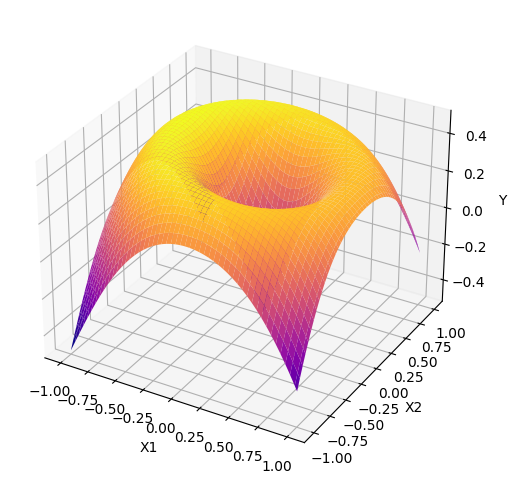

In [29]:
# %matplotlib tk
ax = plt.figure(figsize=(8,6)).add_subplot(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

# Convex NN

In [109]:
EPOCHS = 5000
# actf = nn.LeakyReLU
actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

In [110]:
cvxNet = ConvexNN([2, 15, 15, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

Epoch: 0, Loss:0.2773612439632416


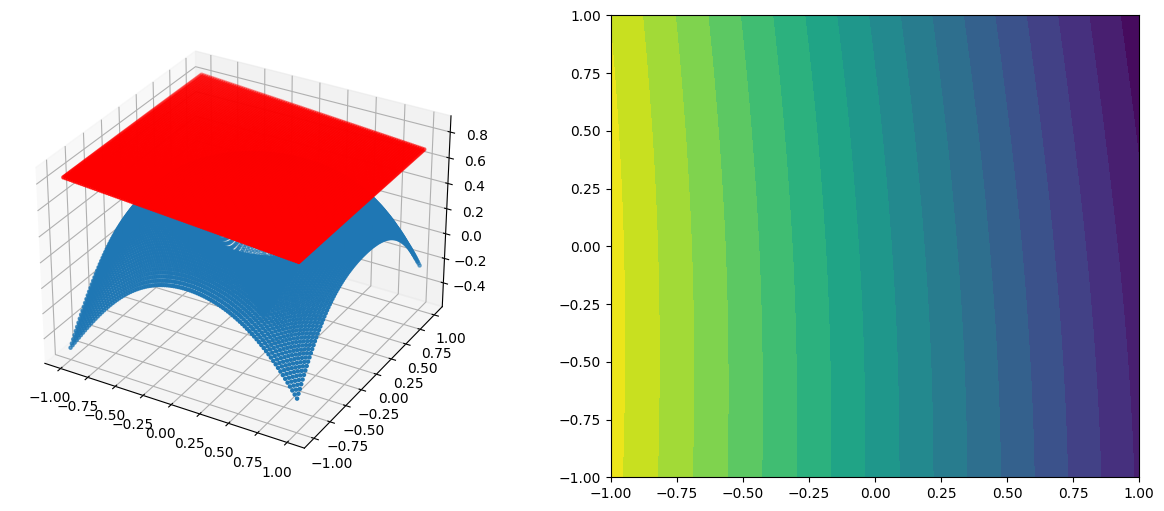

Epoch: 100, Loss:0.031358204782009125
Epoch: 200, Loss:0.028762970119714737
Epoch: 300, Loss:0.024462692439556122
Epoch: 400, Loss:0.020825106650590897
Epoch: 500, Loss:0.019842997193336487
Epoch: 600, Loss:0.019399985671043396
Epoch: 700, Loss:0.019063932821154594
Epoch: 800, Loss:0.018811365589499474
Epoch: 900, Loss:0.018750809133052826
Epoch: 1000, Loss:0.018504513427615166
Epoch: 1100, Loss:0.018425945192575455
Epoch: 1200, Loss:0.018333613872528076
Epoch: 1300, Loss:0.018244381994009018
Epoch: 1400, Loss:0.0182051844894886
Epoch: 1500, Loss:0.018128907307982445
Epoch: 1600, Loss:0.018059520050883293
Epoch: 1700, Loss:0.01800517365336418
Epoch: 1800, Loss:0.017948457971215248
Epoch: 1900, Loss:0.017859725281596184
Epoch: 2000, Loss:0.01774481125175953
Epoch: 2100, Loss:0.017660165205597878
Epoch: 2200, Loss:0.017580600455403328
Epoch: 2300, Loss:0.017588965594768524
Epoch: 2400, Loss:0.01742900162935257
Epoch: 2500, Loss:0.01741730608046055
Epoch: 2600, Loss:0.017271211370825768
E

In [111]:
%matplotlib inline
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

In [113]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

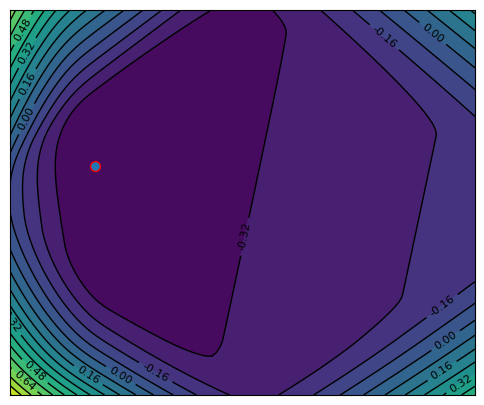

In [117]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx*1.1).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels[1::2], inline=True, fontsize=8, fmt="%1.2f", colors='k')
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=50, edgecolors="red")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/convex_contour_local.pdf", bbox_inches='tight')

## Invex NN

In [104]:
EPOCHS = 5000
learning_rate = 0.005
criterion = nn.MSELoss()

In [105]:
cvxNet = nn.Sequential(
    ActNorm(2),
    irf.ResidualFlow(2, [15], activation=nflib.res_flow.Swish),
    ActNorm(2),
    DistanceRegressor(2),
)

optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

Epoch: 0, Loss:1.7285181283950806


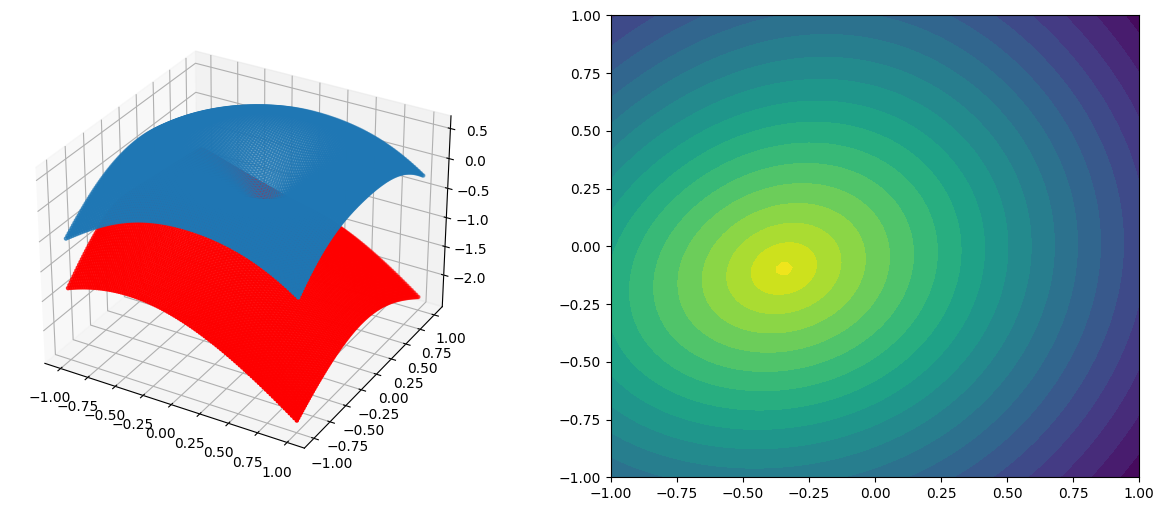

Epoch: 100, Loss:0.04881061986088753
Epoch: 200, Loss:0.04184770584106445
Epoch: 300, Loss:0.032115388661623
Epoch: 400, Loss:0.02620764821767807
Epoch: 500, Loss:0.022900350391864777
Epoch: 600, Loss:0.020461585372686386
Epoch: 700, Loss:0.019171783700585365
Epoch: 800, Loss:0.018671588972210884
Epoch: 900, Loss:0.018079089000821114
Epoch: 1000, Loss:0.01763582043349743
Epoch: 1100, Loss:0.01692705601453781
Epoch: 1200, Loss:0.017587758600711823
Epoch: 1300, Loss:0.017559535801410675
Epoch: 1400, Loss:0.016416754573583603
Epoch: 1500, Loss:0.016721755266189575
Epoch: 1600, Loss:0.01613977923989296
Epoch: 1700, Loss:0.016521234065294266
Epoch: 1800, Loss:0.017180705443024635
Epoch: 1900, Loss:0.015883753076195717
Epoch: 2000, Loss:0.016692018136382103
Epoch: 2100, Loss:0.015351597219705582
Epoch: 2200, Loss:0.016766062006354332
Epoch: 2300, Loss:0.01598477177321911
Epoch: 2400, Loss:0.015094300732016563
Epoch: 2500, Loss:0.015781888738274574
Epoch: 2600, Loss:0.01639510691165924
Epoch:

In [106]:
%matplotlib inline
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

In [107]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

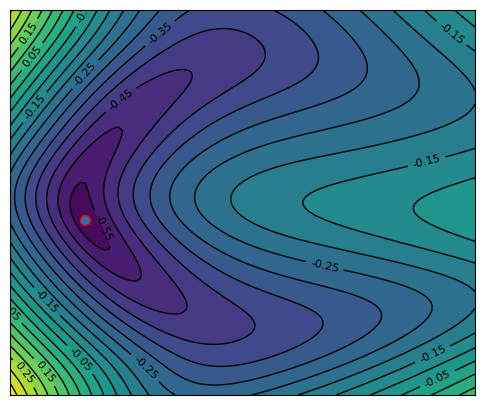

In [108]:
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels[1::2], inline=True, fontsize=8, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=50, edgecolors="red")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/invex_contour_local.pdf", bbox_inches='tight')

## Linear and Radial

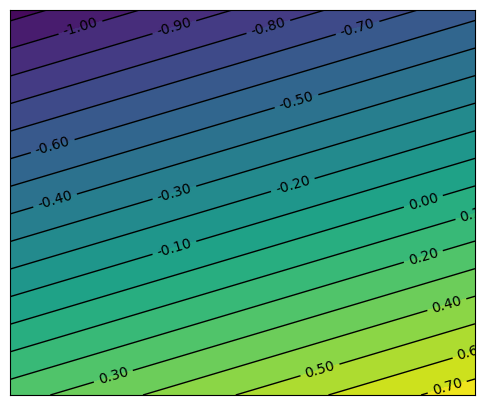

In [124]:
linear = nn.Linear(2, 1)
y = linear(xx).data.numpy().reshape(Y.shape)

LVLs = 20
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, y, levels=LVLs)
cs = plt.contour(X1, X2, y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/linear_contour.pdf", bbox_inches='tight')

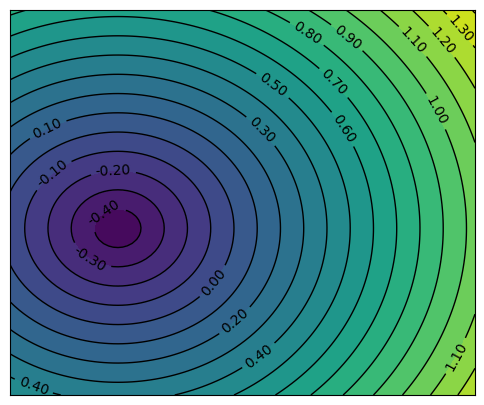

In [130]:
radial = DistanceRegressor(2, 1)
y = radial(xx).data.numpy().reshape(Y.shape)

LVLs = 20
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, y, levels=LVLs)
cs = plt.contour(X1, X2, y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/04.2_locality_contour_viz/radial_contour.pdf", bbox_inches='tight')